In [3]:
import os
import sys
os.environ["TOKENIZERS_PARALLELISM"] = "true"
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import gc
import time
import random
import warnings

warnings.filterwarnings("ignore")
import os
import sys
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
from src.data.preprocess import preprocess_text
from src.dataset.EmotionDataset import get_valid_dataloader, get_train_dataloader, get_test_dataloader
import numpy as np
from src.utils import AverageMeter, time_since, get_config, dictionary_to_namespace
from src.models.utils import get_model
from src.dataset.collators import collate

Since we got the highest result from <b style='color:purple'> microsoft/deberta-v3-large </b> on the validation split we will use that model to further analysis.

In [43]:
config_path ='../config/microsoft-deberta-v3-large-dropout-added.yaml'
feat_col = 'text'
chkpt_path = "../checkpoints/6/best.pth"
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

# Prepare the config

In [44]:
def get_tokenizer(config):
    tokenizer = AutoTokenizer.from_pretrained(config.model.backbone_type,
                                              use_fast=True
                                              )
    tokenizer.save_pretrained(config.general.tokenizer_dir_path)
    return tokenizer 

In [45]:
config = get_config(config_path)
config = dictionary_to_namespace(config)
tokenizer = get_tokenizer(config)
config.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Load data

In [46]:
def load_data():
    # load the dataset
    dataset = load_dataset("dair-ai/emotion")
    dataset.set_format(type="pandas")
    train_df = dataset['train'][:]
    val_df = dataset['validation'][:]
    test_df = dataset['test'][:]
    return train_df, val_df, test_df


In [47]:
train_df, val_df, test_df = load_data()

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/ikhtiyor/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
train_df[feat_col] = train_df[feat_col].apply(preprocess_text)
val_df[feat_col] = val_df[feat_col].apply(preprocess_text)
test_df[feat_col] = test_df[feat_col].apply(preprocess_text)

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
test_dataloader = get_test_dataloader(config, test_df)
train_dataloader = get_test_dataloader(config, train_df)

# Load the model

In [51]:
model = get_model(config)
model.load_state_dict(torch.load(chkpt_path)['model'])
model.to(device)
_ = model.eval()


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> /home/ikhtiyor/Documents/projects/home_projects/nlp_task/src/models/utils.py(60)get_model()
     57             if(layers is None):
     58                 layers = getattr(model.backbone.encoder, 'layers', None)
     59             for module in layers[-config.model.reinitialize_n_layers:]:
---> 60                 model._init_weights(module)
     61     return model

ipdb> c


# Make prediction

In [17]:
def test_fn(config, test_dataloader, model, device, half=False):
    model.eval()
    if(half):
        model = model.half()
    predictions = []
    outputs = []
    label_all = []
    start = time.time()

    for step, (inputs, labels) in enumerate(test_dataloader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)#.half() if half else v.to(device)
        labels = labels.to(device)

        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)

        outputs.append(y_preds.to('cpu').numpy())
        predictions.append(torch.softmax(y_preds,1).argmax(1).to('cpu').numpy())
        label_all.append(labels.to('cpu').numpy())

    predictions = np.concatenate(predictions)
    outputs = np.concatenate(outputs)
    label_all = np.concatenate(label_all)
    return label_all, predictions, outputs

# Float32 Based model results

In [52]:
ys, y_preds, outputs = test_fn(config, test_dataloader, model, device)

## Plot the confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_metrics(ys, y_preds):
    cm = confusion_matrix(ys, y_preds)


    disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
    disp.plot()

    from sklearn.metrics import classification_report
    print('--------------------------------'*2)
    print('additional metrics')
    print('--------------------------------'*2)
    print(classification_report(ys, y_preds, target_names=emotions))

    print('--------------------------------'*2)

    print("accuracy:", np.sum(ys==y_preds)/len(ys))
    return np.sum(ys==y_preds)/len(ys)

----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.94      0.95       695
        love       0.81      0.89      0.84       159
       anger       0.93      0.93      0.93       275
        fear       0.89      0.86      0.87       224
    surprise       0.67      0.83      0.74        66

    accuracy                           0.93      2000
   macro avg       0.87      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000

----------------------------------------------------------------
accuracy: 0.9295


0.9295

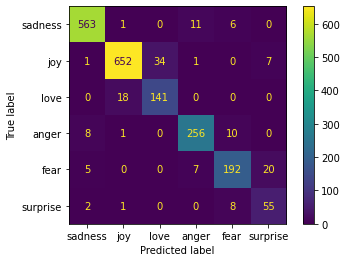

In [20]:
print_metrics(ys, y_preds)

## Test Metrics:
- Accuracy: 0.93
- Macro F1: 0.89
- Weighted F1: 0.93
- Macro Precision: 0.89
- Weighted Precision: 0.93
- Weighted Recall: 0.93

# float 16 based metrics

In [21]:
ys, y_preds, outputs = test_fn(config, test_dataloader, model, device, half=True)

----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.94      0.95       695
        love       0.81      0.89      0.84       159
       anger       0.93      0.93      0.93       275
        fear       0.89      0.86      0.87       224
    surprise       0.67      0.83      0.74        66

    accuracy                           0.93      2000
   macro avg       0.87      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000

----------------------------------------------------------------
accuracy: 0.9295


0.9295

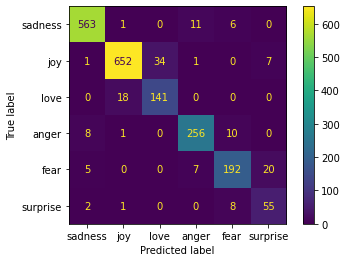

In [22]:
print_metrics(ys, y_preds)

# Pruning

In [23]:

def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    # https://leimao.github.io/blog/PyTorch-Pruning/
    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = (num_zeros / num_elements) if (num_elements > 0) else None

    return num_zeros, num_elements, sparsity

def measure_global_sparsity(model,
                            weight=True,
                            bias=False, use_mask=False):
    # https://leimao.github.io/blog/PyTorch-Pruning/
    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():
        module_num_zeros, module_num_elements, _ = measure_module_sparsity(
            module, weight=weight, bias=bias, use_mask=use_mask)
        num_zeros += module_num_zeros
        num_elements += module_num_elements
    sparsity = num_zeros / num_elements
    return num_zeros, num_elements, sparsity

class Pruner:
    def __init__(self, model:torch.nn.Module, layers, percentage) -> None:
        """
        Args:
            model: nn.Module
            layers: list of layers to be pruned
            percentage: (0-1) ranged float, the percentage of the model should be pruned
            pruning_method:
                by default prune.L1Unstructured which uses l1 value do decide to prune the weights
        """

        self.model = model
        self.percentage = percentage
        self.layers = layers

        # we now only support unstructured pruning
        self.pruning_method = prune.L1Unstructured
    
        self.prepare_params()

    def prepare_params(self):
        params_to_prune  = []
        for module in self.model.modules():
#             print('module', module)
            if(self.layers.get(type(module), None) is not None):
                params_to_prune.append((module, 'weight'))
        self.params_to_prune = tuple(params_to_prune)

    def prune(self):
        print("starting to prune")
        prune.global_unstructured(self.params_to_prune, pruning_method=self.pruning_method, amount=self.percentage)
        print("pruning is finished")
        
    
    def remove_params(self):
        print('starting to remove original weights')
        for layer, param_name in self.params_to_prune:
            prune.remove(layer, 'weight')
        print("removing the original layers finished")

    def show_model_statistics(self):
        num_zeros, num_elements, sparsity = measure_global_sparsity(
            self.model,
            weight=True,
            bias=False,
            use_mask=True)
        print("Global Sparsity:")
        print("{:.2f}".format(sparsity))


In [24]:
import copy 
import torch.nn as nn
from torch.nn.utils import prune
import matplotlib.pyplot as plt
import gc

########################################################################################################################
proportion is  0.1111111111111111
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.97      0.94      0.95       695
        love       0.81      0.88      0.84       159
       anger       0.93      0.93      0.93       275
        fear       0.90      0.85      0.87       224
    surprise       0.67      0.85      0.75        66

    accuracy                           0.93      2000
   macro avg       0.87      0.90      0.89    

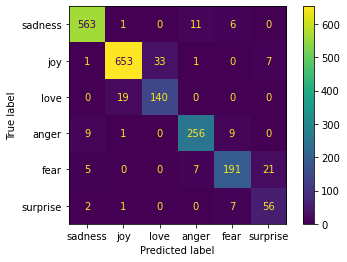

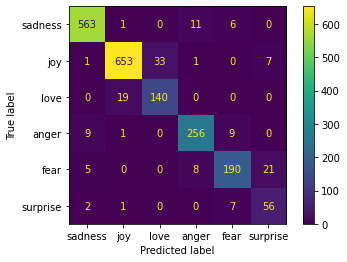

########################################################################################################################
proportion is  0.2222222222222222
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.97       581
         joy       0.96      0.94      0.95       695
        love       0.82      0.87      0.85       159
       anger       0.94      0.92      0.93       275
        fear       0.89      0.86      0.87       224
    surprise       0.67      0.85      0.75        66

    accuracy                           0.93      2000
   macro avg       0.87      0.90      0.89    

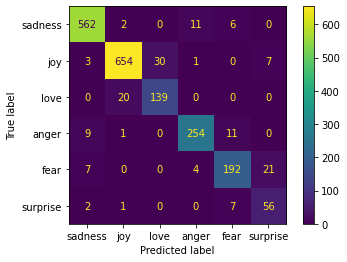

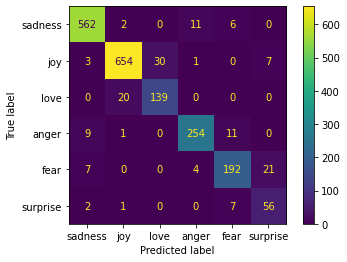

########################################################################################################################
proportion is  0.3333333333333333
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.97       581
         joy       0.96      0.95      0.95       695
        love       0.84      0.87      0.85       159
       anger       0.94      0.91      0.92       275
        fear       0.86      0.91      0.88       224
    surprise       0.72      0.73      0.72        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88    

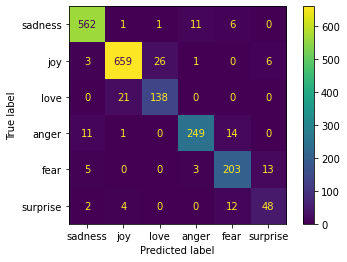

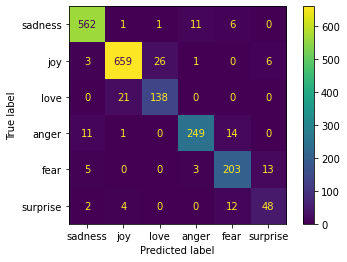

########################################################################################################################
proportion is  0.4444444444444444
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.96      0.95      0.95       581
         joy       0.90      0.97      0.93       695
        love       0.89      0.70      0.79       159
       anger       0.95      0.86      0.90       275
        fear       0.82      0.93      0.87       224
    surprise       0.75      0.61      0.67        66

    accuracy                           0.91      2000
   macro avg       0.88      0.84      0.85    

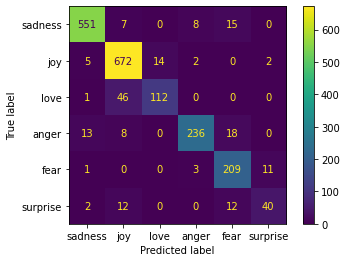

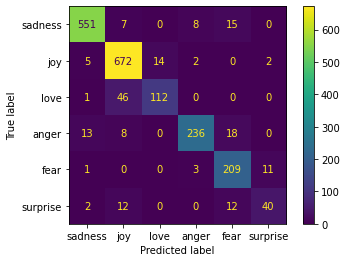

########################################################################################################################
proportion is  0.5555555555555556
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.87      0.74      0.80       581
         joy       0.57      0.99      0.73       695
        love       0.79      0.09      0.17       159
       anger       0.98      0.22      0.36       275
        fear       0.71      0.68      0.69       224
    surprise       0.50      0.02      0.03        66

    accuracy                           0.67      2000
   macro avg       0.74      0.46      0.46    

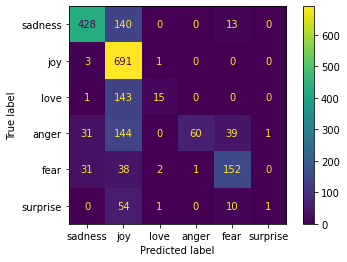

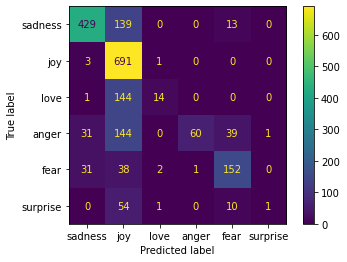

########################################################################################################################
proportion is  0.6666666666666666
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       581
         joy       0.35      1.00      0.52       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.06      0.17      0.09    

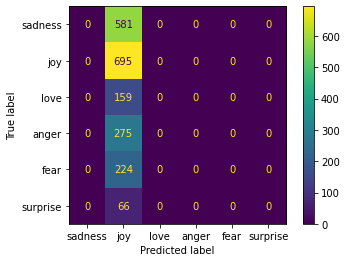

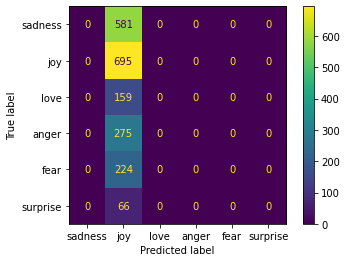

########################################################################################################################
proportion is  0.7777777777777777
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.40      0.00      0.01       581
         joy       0.35      1.00      0.52       695
        love       0.00      0.00      0.00       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.12      0.17      0.09    

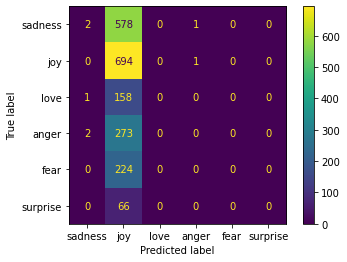

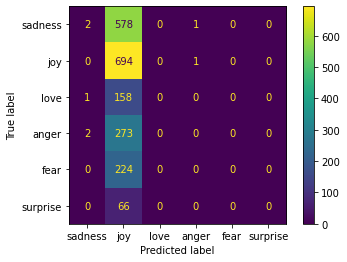

########################################################################################################################
proportion is  0.8888888888888888
length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False
for full:
----------------------------------------------------------------
additional metrics
----------------------------------------------------------------
              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       581
         joy       0.00      0.00      0.00       695
        love       0.08      1.00      0.15       159
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.08      2000
   macro avg       0.01      0.17      0.02    

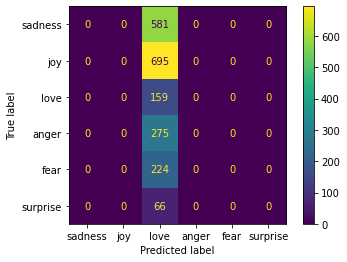

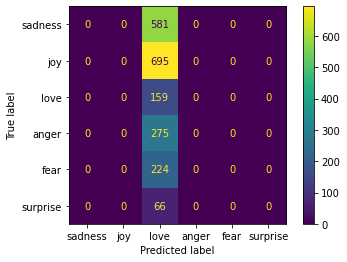

In [27]:
results = []
results_half = []
for proportion in np.linspace(0, 1, 10)[1:-1]:
    print('########################'*5)
    print("proportion is ", proportion)
    layers = {nn.Linear:True}
    model2prune = copy.deepcopy(model.cpu())
    pruner = Pruner(model2prune, layers, proportion)
    print('length ofparams to prune', len(pruner.params_to_prune))
    pruner.prune()
    print('before removing the params', prune.is_pruned(model2prune))
    pruner.remove_params()
    print('after removing the params', prune.is_pruned(model2prune))
    
    print("for full:")
    ys, y_preds, outputs = test_fn(config, test_dataloader, model2prune.cuda(), device, half=False)
    acc = print_metrics(ys, y_preds)
    results.append([proportion, acc])
    
    
    print("for half:")
    ys, y_preds, outputs = test_fn(config, test_dataloader, model2prune.cuda().half(), device, half=True)
    acc = print_metrics(ys, y_preds)
    results_half.append([proportion, acc])
    
    plt.show()
    del model2prune
    gc.collect()

In [28]:
results = np.array(results)
results_half = np.array(results_half)

Text(0, 0.5, 'accuracy')

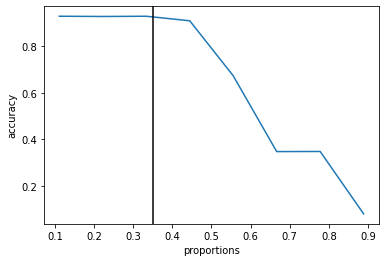

In [29]:
plt.plot(results[:,0], results[:,1])
plt.axvline(x=0.35, c='black')
plt.xlabel('proportions')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

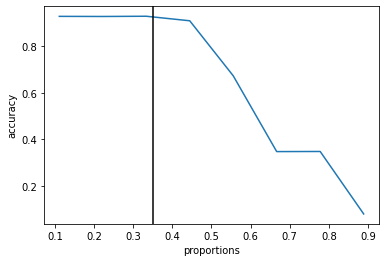

In [30]:
plt.plot(results_half[:,0], results_half[:,1])
plt.axvline(x=0.35, c='black')
plt.xlabel('proportions')
plt.ylabel('accuracy')

In [41]:
model2prune = copy.deepcopy(model.cpu())
pruner = Pruner(model2prune, layers, 0.35)
print('length ofparams to prune', len(pruner.params_to_prune))
pruner.prune()
print('before removing the params', prune.is_pruned(model2prune))
pruner.remove_params()
print('after removing the params', prune.is_pruned(model2prune))

length ofparams to prune 146
starting to prune
pruning is finished
before removing the params True
starting to remove original weights
removing the original layers finished
after removing the params False


In [50]:
pytorch_total_params = sum(p.numel() for p in model2prune.parameters())
print(pytorch_total_params)

434438662


In [51]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

434438662


In [61]:
measure_global_sparsity(model2prune, use_mask=False)

(777320312, 2742940672, 0.28338940026479725)

In [59]:
measure_global_sparsity(model, use_mask=False)

(49660, 2742940672, 1.8104656986179247e-05)

# Debug the cases where the model fails

In [92]:
ys, y_preds, outputs = test_fn(config, test_dataloader, model, device)

In [93]:
df= test_df

In [94]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

In [95]:
df['pred'] = y_preds

In [96]:
df['name'] = df['label'].apply(lambda x: labels_dict[x])
df['name_pred'] = df['pred'].apply(lambda x: labels_dict[x])

In [97]:
wrongs = df[~(df.label == df.pred)]

In [98]:
wrongs.head()

,text,label,pred,name,name_pred
10,i don t feel particularly agitated,4,3,fear,anger
40,i feel if i completely hated things i d exerci...,3,0,anger,sadness
67,i feel a bit stressed even though all the thin...,3,0,anger,sadness
72,i am right handed however i play billiards lef...,5,4,surprise,fear
86,i feel like i am in paradise kissing those swe...,1,2,joy,love


In [109]:
wrongs.iloc[11].to_numpy()

array(['i feel blessed to know this family', 2, 1, 'love', 'joy'],
      dtype=object)

In [100]:
# df.to_csv('pseudo_labels.csv', index=False)

In [101]:
(wrongs.name == 'anger').sum()

20

In [102]:
wrongs.shape

(137, 5)

In [104]:
test_df.shape

(2000, 5)

In [106]:
1- wrongs.shape[0]/test_df.shape[0]

0.9315

In [110]:
sum([0.1,0.1,0.15,0.15,0.2,0.3])

1.0